<h1> ______________________________________ </h1>

<h1> Full NEXT100 with fiber panels simulation mapping analysis </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we take as input the maps created in the previous notebook and use it to simulate an s2 signal for bb0nu events. </p>




<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> 100K ie S2 events. </p>
-  <p style="font-size: 17px; color: black;"> Mapping separated by sensors. </p>

-  <p style="font-size: 17px; color: black;"> Geant4 fundamental units: </p>

 -  <p style="font-size: 17px; color: black;"> Length [L]: mm (milimeter) </p>
 -  <p style="font-size: 17px; color: black;"> Time [T]: ns (nanosecond) </p>
 -  <p style="font-size: 17px; color: black;"> Energy [E]: MeV (megaelectronvolt) </p>





In [1]:
import numpy              as np
import pandas             as pd

import scipy              
from scipy                import stats, integrate
from scipy.signal         import convolve

import matplotlib.pyplot  as plt

from matplotlib.ticker    import FormatStrFormatter # to set the format of the plot's axis
from matplotlib.patches   import Rectangle # To add blanck spaces in tabular legends

import os
import math
import tables             as tb

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/Next100_full_mapp_s2_inicioEL_100Kev.next.h5 (File) ''
Last modif.: '2023-11-14T11:00:27+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(49,)) ''
/MC/hits (Table(0,)) ''
/MC/particles (Table(100000,)) ''
/MC/sns_positions (Table(3524,)) ''
/MC/sns_response (Table(1455365,)) ''



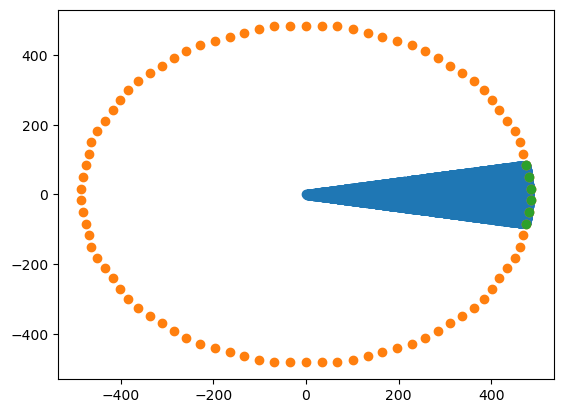

/tmp/ipykernel_322505/1926091879.py:14: RuntimeWarning: invalid value encountered in true_divide
  hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);
/tmp/ipykernel_322505/1005221130.py:27: RuntimeWarning: invalid value encountered in double_scalars
  std_value*100/(np.sqrt(entries_value)*mean_value),


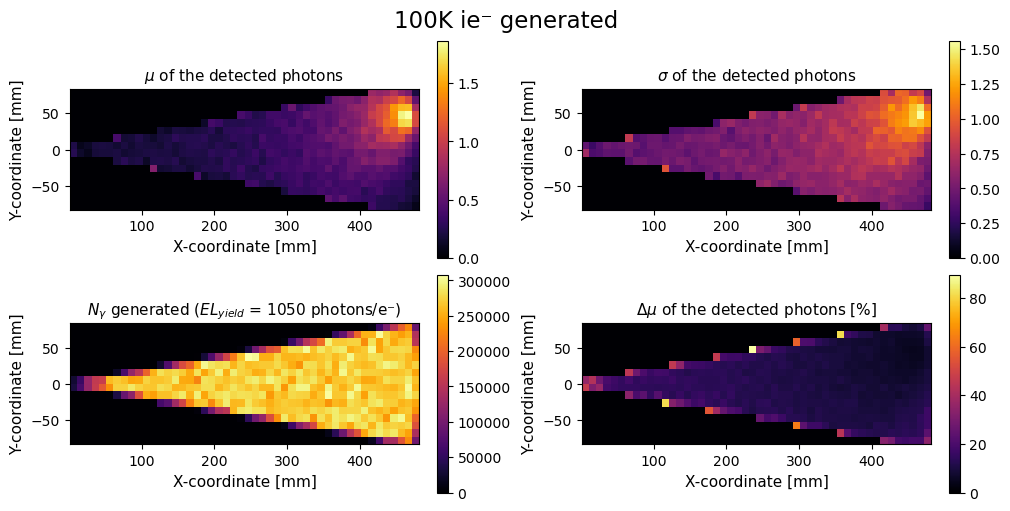

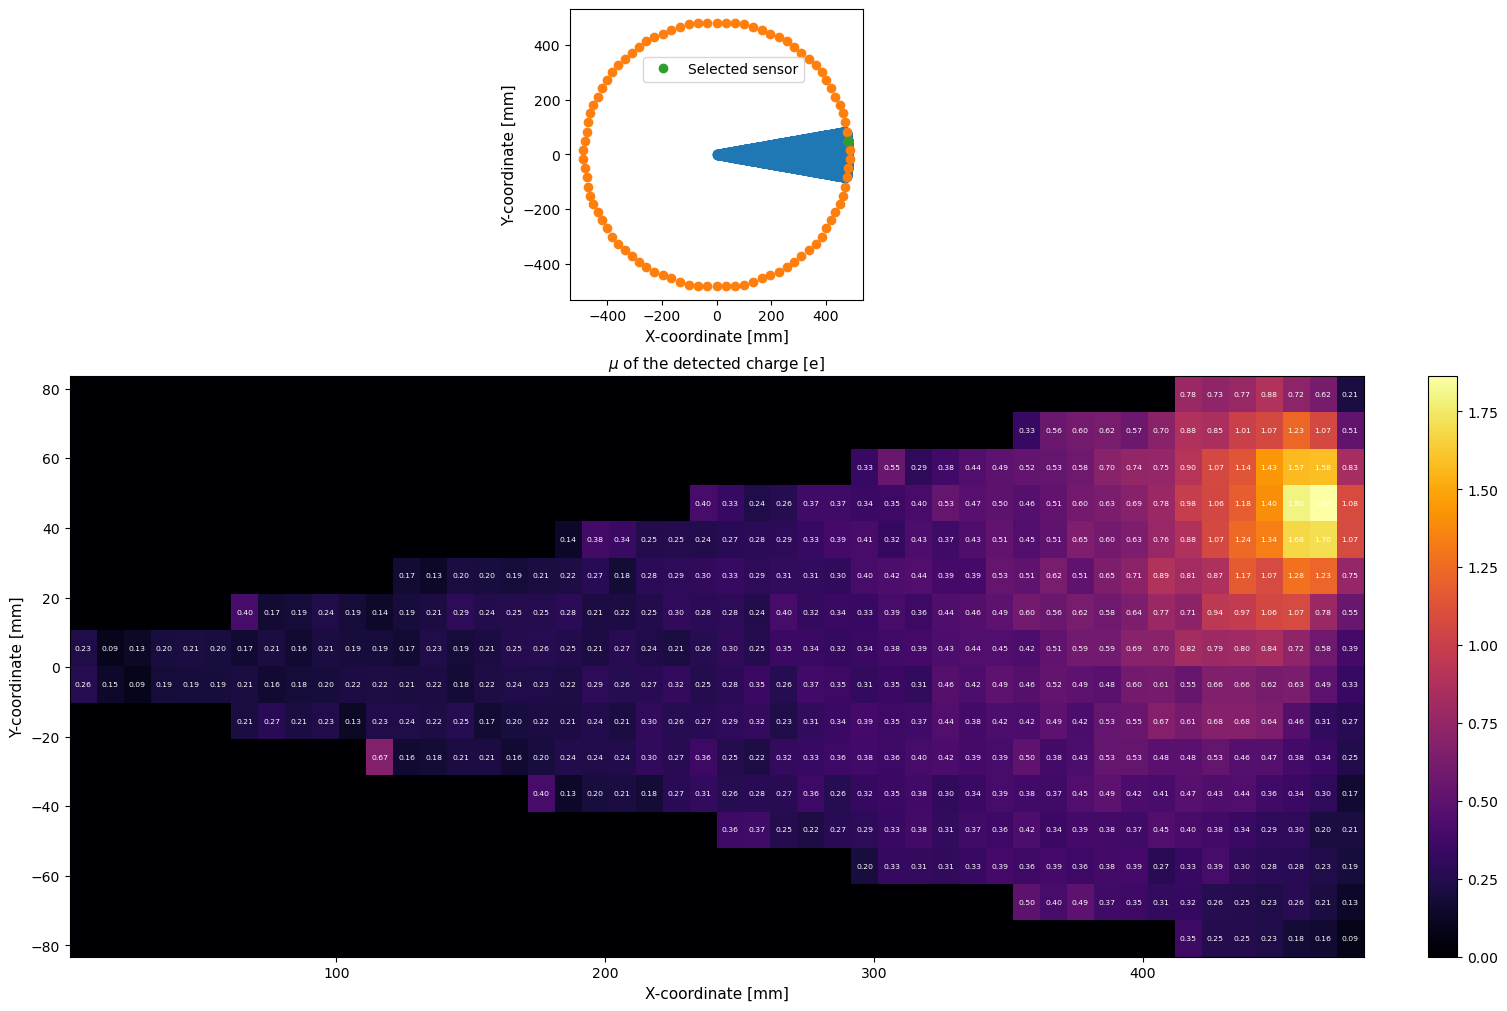

In [2]:
%run '/home/investigator/mariandbt/python/notebooks/20231116_NEXT100_S2_mapping.ipynb'

In [116]:
def sens_map(selected_id):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10), constrained_layout=True)

    ax.plot(sens_fibers.x, sens_fibers.y, 'o', markersize = 2*font_size)

    for sens_id in sens_fibers.sensor_id:
        xx = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].x)
        yy = float(sens_fibers.loc[sens_fibers.sensor_id == sens_id].y)

        ax.annotate(f'{sens_id:.0f}', (xx, yy),
                    color='black', ha='center', va='center', fontsize = font_size)

    if selected_id in sens_fibers.sensor_id.values:
        ax.plot(sens_fibers.loc[sens_fibers.sensor_id == selected_id].x, 
                sens_fibers.loc[sens_fibers.sensor_id == selected_id].y, 'o', 
                markersize = 2*font_size, label = 'Selected sensor')

        ax.legend(loc = 'center')

    else:
        ax.annotate('Not (valid) sensor ID selected', (0, 0),
                    color='black', ha='center', va='center', fontsize = font_size)

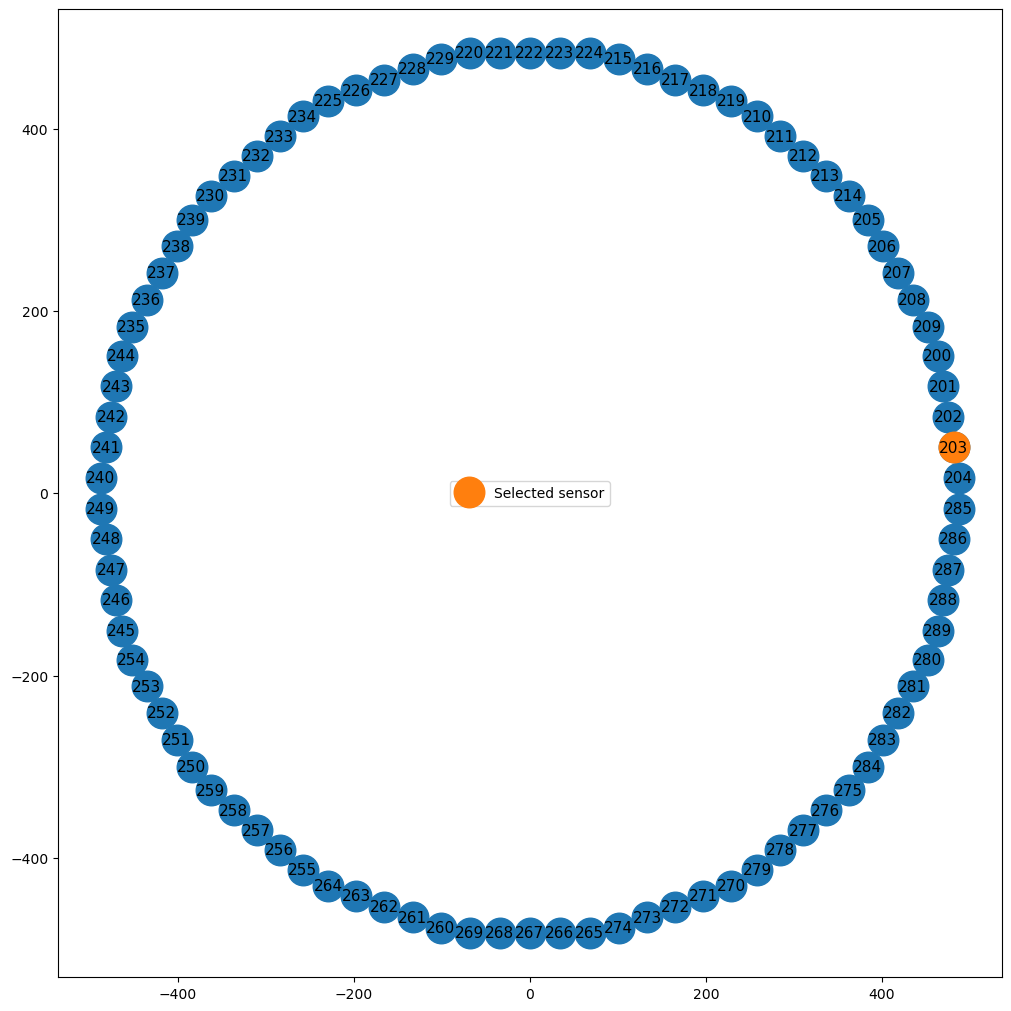

In [117]:
sens_map(selected_sens)

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [71]:
path = '/home/investigator/mariandbt/python/data'
path = path + '/20231025_NEXT100_full_mapping'

filename = os.path.join(path, "Next100_bb.next.h5")


-  <p style="font-size: 17px; color: black;"> In a .h5 file there are several objects, so we print them all to then pick the one we're interested in </p>

In [72]:
with tb.open_file(filename) as file:
    print(file)

/home/investigator/mariandbt/python/data/20231025_NEXT100_full_mapping/Next100_bb.next.h5 (File) ''
Last modif.: '2023-12-04T17:20:09+00:00'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/configuration (Table(46,)) ''
/MC/hits (Table(810,)) ''
/MC/particles (Table(109720,)) ''
/MC/sns_positions (Table(136,)) ''
/MC/sns_response (Table(1445,)) ''



In [73]:
# %%timeit # WITH THIS YOU'RE ONLY TIMING, BUT IT DOESN'T REALLY RUN THE COMMANDS YOU TIME
bb_particles = pd.read_hdf(filename, "/MC/particles")
bb_sensors = pd.read_hdf(filename, "/MC/sns_positions")
bb_data = pd.read_hdf(filename, "/MC/sns_response")


In [74]:
bb_dst_particle = bb_particles.copy()
bb_sens = bb_sensors.copy()
bb_dst = bb_data.copy()


In [92]:
bb_ie = bb_dst_particle.loc[bb_dst_particle.particle_name == 'ie-'].copy()
bb_ie.loc[:, 's2'] = 0 # we add a column to save the s2 signal in [e] each ie⁻ produces

In [93]:
bb_ie

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,s2
0,0,242,ie-,0,2,256.111298,-40.916672,596.808167,0.002822,255.334656,-26.839602,-0.101,599040.7500,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
1,0,241,ie-,0,2,255.913925,-41.441330,596.515015,0.000663,259.082855,-18.696661,-0.101,598746.5000,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
2,0,240,ie-,0,2,255.965851,-41.303299,596.592102,0.001231,253.311218,-46.559612,-0.101,596652.8125,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
3,0,239,ie-,0,2,256.081177,-40.996746,596.763428,0.002493,254.095886,-51.926403,-0.101,595883.1875,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
4,0,238,ie-,0,2,256.126526,-40.876194,596.830811,0.002989,264.304260,-48.262009,-0.101,595971.8125,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
5,0,237,ie-,0,2,255.979248,-41.267693,596.612000,0.001378,257.516602,-28.316290,-0.101,597031.7500,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
6,0,236,ie-,0,2,256.084595,-40.987640,596.768494,0.002530,261.069550,-34.354336,-0.101,595295.1250,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
7,0,235,ie-,0,2,256.050262,-41.078926,596.717529,0.002155,244.691055,-31.666224,-0.101,602051.7500,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
8,0,234,ie-,0,2,256.111084,-40.917233,596.807861,0.002820,245.235199,-46.998825,-0.101,595785.6875,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0
9,0,233,ie-,0,2,256.078949,-41.002682,596.760132,0.002468,245.475204,-51.285816,-0.101,591895.8125,ACTIVE,EL_GAP,0.0,0.0,0.001011,0.0,0.0,0.001011,0.000001,1.0,Clustering,Drift,0


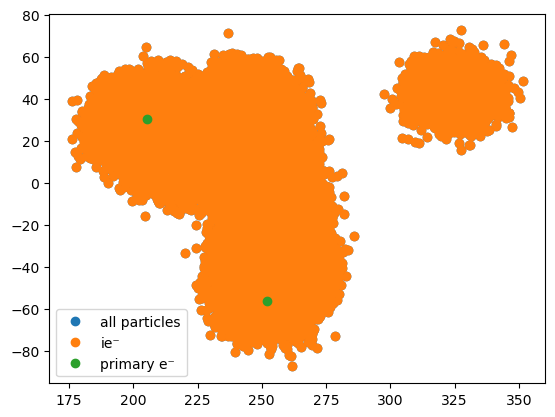

In [104]:
plt.plot(bb_dst_particle.final_x, bb_dst_particle.final_y, 'o', label = 'all particles')
plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'ie⁻')
plt.plot(bb_dst_particle.loc[bb_dst_particle.primary == 1].final_x, 
         bb_dst_particle.loc[bb_dst_particle.primary == 1].final_y, 'o', label = 'primary e⁻')
plt.legend()
plt.show()

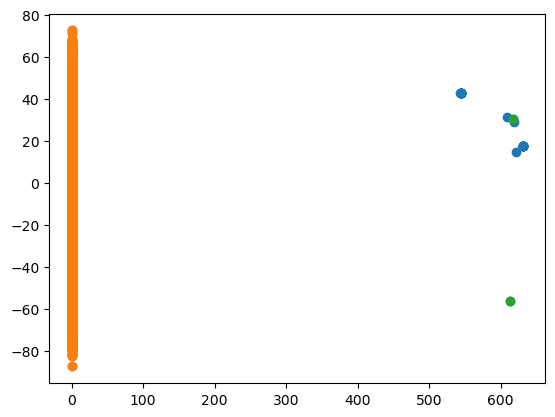

In [105]:
plt.plot(bb_dst_particle.final_z, bb_dst_particle.final_y, 'o')
plt.plot(bb_ie.final_z, bb_ie.final_y, 'o')
plt.plot(bb_dst_particle.loc[bb_dst_particle.primary == 1].final_z, 
         bb_dst_particle.loc[bb_dst_particle.primary == 1].final_y, 'o')
plt.show()

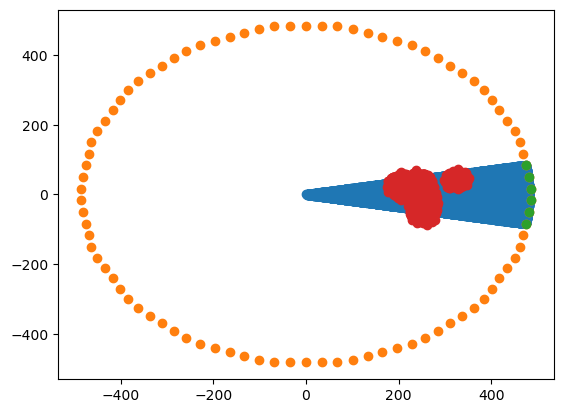

In [109]:
plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
plt.plot(fib_sens.x, fib_sens.y, 'o')

sector_sens = fib_sens.loc[(fib_sens.y > dst_particle.initial_y.min() - 10) &
                           (fib_sens.y < dst_particle.initial_y.max() + 10) &
                           (fib_sens.x > 0.)
                          ]
plt.plot(sector_sens.x, sector_sens.y, 'o')
plt.plot(bb_ie.final_x, bb_ie.final_y, 'o', label = 'ie⁻')

plt.show()

In [134]:
n_panels = 18
dtheta = 2*np.pi/n_panels # rad
active_diam = 984 # [mm]

In [216]:
xx = -bb_ie.loc[bb_ie.final_y == bb_ie.final_y.min()].final_x.values
yy = bb_ie.final_y.min()

In [217]:
def find_rot(xx, yy):
    rot = -9
    while not ((rot < n_panels) & 
               (yy > xx*np.tan(-dtheta/2. + dtheta*(rot))) & 
               (yy < xx*np.tan(dtheta/2. + dtheta*(rot)))).all():
        rot += 1
    
    return rot

In [218]:
rr = find_rot(xx, yy)
rr

-5

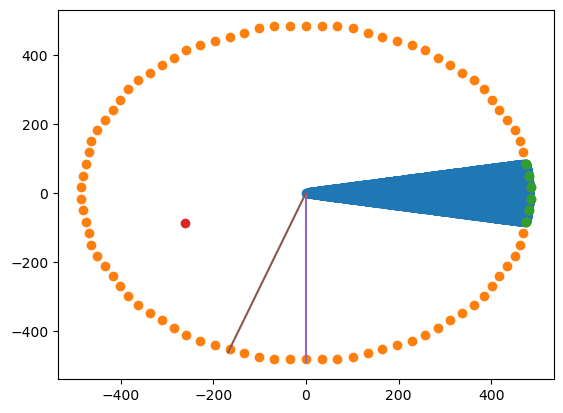

In [219]:
plt.plot(dst_particle.initial_x, dst_particle.initial_y, 'o')

fib_sens = sens.loc[sens.sensor_name == "F_SENSOR"]
plt.plot(fib_sens.x, fib_sens.y, 'o')

sector_sens = fib_sens.loc[(fib_sens.y > dst_particle.initial_y.min() - 10) &
                           (fib_sens.y < dst_particle.initial_y.max() + 10) &
                           (fib_sens.x > 0.)
                          ]
plt.plot(sector_sens.x, sector_sens.y, 'o')

plt.plot(xx, yy, 'o', label = 'ie⁻')

radius = np.linspace(0, active_diam/2, 100)
# rr = 14
xx_ = radius*np.cos(dtheta/2 + dtheta*(rr))
plt.plot(xx_ , xx_*np.tan(dtheta/2 + dtheta*(rr)))
xx_ = radius*np.cos(-dtheta/2 + dtheta*(rr))
plt.plot(xx_ , xx_*np.tan(-dtheta/2 + dtheta*(rr)))

plt.show()

In [127]:
from matplotlib.transforms import Affine2D

# Create some sample data
x = dst_particle.initial_x
y = dst_particle.initial_y

# Create a plot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Original Plot')

# Define a rotation angle in degrees
angle = -2

# Create a transformation matrix for rotation
transform = Affine2D().rotate_deg(angle)

# Apply the rotation to the plot
ax.set_transform(transform + ax.transData)

# Show the plot
plt.show()



OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 640x480 with 1 Axes>

In [106]:
i = 3

In [107]:
bb_ie.loc[(bb_ie.final_x >= xedges[i]) &
          (bb_ie.final_x < xedges[i + 1]) &
          (bb_ie.final_y >= yedges[i]) &
          (bb_ie.final_y < yedges[i + 1]) 
         ]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,initial_volume,final_volume,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc,s2


In [94]:
mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                    (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))


In [3]:
for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)[50:90]):
# for ii, selected_sens in enumerate(np.sort(sens_fibers.sensor_id)):

    print(f'{ii:.0f}/{len(sens_fibers)}')

    sens_response = dst.loc[dst.sensor_id == selected_sens] # response of the selected sensor

    # keep track of the events with no counts
    no_counts_events = set(range(n_events)) - set(sens_response.event_id.unique()) 
    # print(f'Events {no_counts_events} did not have any counts')

    # Create a DataFrame with all event IDs
    all_event_ids = pd.DataFrame({'event_id': range(n_events)})

    # Merge the two DataFrames to align charge values
    sens_response = all_event_ids.merge(sens_response, on='event_id', how='left').fillna(0)


    event_charge = sens_response.groupby("event_id").charge.sum() # total charge detected on each event

# ****************************************************************************************

    # Create a 2D histogram
    hist, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                          bins=bins, 
                                          weights = event_charge,
                                          density=False);

    hist_counts, xedges, yedges = np.histogram2d(ev_x0, ev_y0, 
                                                 bins=bins, 
                                                 density=False);

    # Calculate the mean values in each bin (normalized histogram)
    hist_norm = np.where(hist_counts > 0., hist / hist_counts, 0.);

# ****************************************************************************************
    # Initialize lists to store statistics for each bin
    mean_per_bin = np.zeros((x_nbins, y_nbins))

    # Iterate over each bin
    for i in range(x_nbins):
        for j in range(y_nbins):
            # Indices of data points in the current bin
            mask = ((ev_x0 >= xedges[i]) & (ev_x0 < xedges[i + 1]) & 
                    (ev_y0 >= yedges[j]) & (ev_y0 < yedges[j + 1]))

            # Extract values and weights in the current bin
            values_in_bin = event_charge[mask]

            # Calculate weighted mean and standard deviation
            mean_value = np.mean(values_in_bin)

            # Append to lists
            mean_per_bin[i][j] = mean_value

    mean_per_bin = np.nan_to_num(mean_per_bin)
# ****************************************************************************************



100000

<h1> _________________________________________________________________________________________________________ </h1>
